# Path Planning On a Grid (Dijkstra with SearchNodes)

![1](./image/1.png)

In this lab we consider the problem of finding a (shortest) path on a graph of special structure, widely used in robotics and computer games, i.e. a grid. Grid is composed of the free and blocked cells and an agent may move from one free cell to the other. The connectivity of the grid may vary, e.g. grid might be 4-connected when only cardinal moves are allowed, 8-connected when diagonal moves are allowed as well, etc. 

**In this lab we assume that the grid is 4-connected**, i.e. only moves into the cardinal direction (N,E,W,S) are allowed. The cost of each move is uniform, i.e. 1.

We will consider the semminal `Dijkstra`'s algorithm for finding the shortest path on a grid. However, we are interested in implementing this algorithm as a "heuristic search without heuristic", i.e. with the distinct 'SearchNode' structure, with Open and Closed etc.

The further algorithms we will be considering (in the next handouts) will re-use much of this implementation, so it's very important that you end up with a correct and efficient code.

Your task is to complete and run every cell in this notebook.

Let's go for it!

![2](./image/dijkstra.png)

In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from heapq import heappop, heappush, heapify

from functools import total_ordering
%matplotlib inline

### Grid map representation 

Square grid map class represents the environment for our moving agent

- width -- the number of columns in the grid
- height -- the number of rows in the grid
- cells -- the binary matrix, that represents the grid. 0 - cell is traversable, 1 - cell is blocked

In [2]:
class Map:

    def __init__(self):
        '''
        Default constructor
        '''

        self._width = 0
        self._height = 0
        self._cells = []
    

    def read_from_string(self, cell_str, width, height):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        '''
        self._width = width
        self._height = height
        self._cells = [[0 for _ in range(width)] for _ in range(height)]
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self._cells[i][j] = 0
                    elif c == '#':
                        self._cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def set_grid_cells(self, width, height, grid_cells):
        '''
        Initialization of map by list of cells.
        '''
        self._width = width
        self._height = height
        self._cells = grid_cells


    def in_bounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self._width) and (0 <= i < self._height)
    

    def traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return not self._cells[i][j]


    def get_neighbors(self, i, j):
        '''
        Get a list of neighbouring cells as (i,j) tuples.
        It's assumed that grid is 4-connected (i.e. only moves into cardinal directions are allowed)
        '''   
        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]

        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))

        return neighbors

    def get_size(self):
        return (self._height, self._width)


Computes the cost of a transition from cell `(i1, j1)` to cell `(i2, j2)`. In case of 4-connected grid it is always equal to 1. However if the connectivity of a grid exceeds 4 the cost of a transition may vary.

Recall that in this lab we assume 4-connected grid, i.e. only cardinal moves are allowed.

In [3]:
def compute_cost(i1, j1, i2, j2):
    '''
    Computes cost of simple moves between cells
    '''
    if abs(i1 - i2) + abs(j1 - j2) == 1: #cardinal move
        return 1
    else:
        raise Exception('Trying to compute the cost of non-supported move! ONLY cardinal moves are supported.')


### Search Node

Search node is the core concept for any (heuristic) search algorithm. It ties together and encapsulates data both about the state of the problem at hand (in the considered case state = the position of the robot/agent on a grid) and data needed to conduct the search (g-, h, f-values etc.)



In [4]:
@total_ordering
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node // always 0 for Dijkstra
    - F: f-value of the node // always equal to g-value for Dijkstra
    - parent: pointer to the parent-node 

    '''

    def __init__(self, i, j, g = 0, h = 0, f = None, parent = None):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f        
        self.parent = parent

    
    def is_goal(self, goal_i, goal_j):
        return self.i == goal_i and self.j == goal_j
    
    def __eq__(self, other):
        return self.i == other.i and self.j == other.j
    
    def __lt__(self, other):
        return self.g < other.g
    
    def __hash__(self):
        return hash((self.i, self.j))

### Visualization

In [5]:
def draw(grid_map, start = None, goal = None, path = None, nodes_opened = None, nodes_expanded = None, nodes_reexpanded = None):
    '''
    Auxiliary function that visualizes the environment, the path and 
    the expanded/not yet expanded/re-expanded nodes.
    Re-expansions are not happening in Dijkstra, but still...
    
    The function assumes that nodes_opened/nodes_expanded/nodes_reexpanded
    are iterable collestions of SearchNodes
    '''
    k = 5
    height, width = grid_map.get_size()
    h_im = height * k
    w_im = width * k
    im = Image.new('RGB', (w_im, h_im), color = 'white')
    draw = ImageDraw.Draw(im)
    
    for i in range(height):
        for j in range(width):
            if(not grid_map.traversable(i, j)):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodes_opened is not None:
        for node in nodes_opened:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)
    
    if nodes_expanded is not None:
        for node in nodes_expanded:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(131, 145, 146), width=0)
    
    if nodes_reexpanded is not None:
        for node in nodes_reexpanded:
                draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(255, 145, 146), width=0)
    
    if path is not None:
        for step in path:
            if (step is not None):
                if (grid_map.traversable(step.i, step.j)):
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (grid_map.traversable(start.i, start.j)):
        draw.rectangle((start.j * k, start.i * k, (start.j + 1) * k - 1, (start.i + 1) * k - 1), fill=(40, 180, 99), width=0)
    
    if (goal is not None) and (grid_map.traversable(goal.i, goal.j)):
        draw.rectangle((goal.j * k, goal.i * k, (goal.j + 1) * k - 1, (goal.i + 1) * k - 1), fill=(231, 76, 60), width=0)


    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()


Example of the visualization

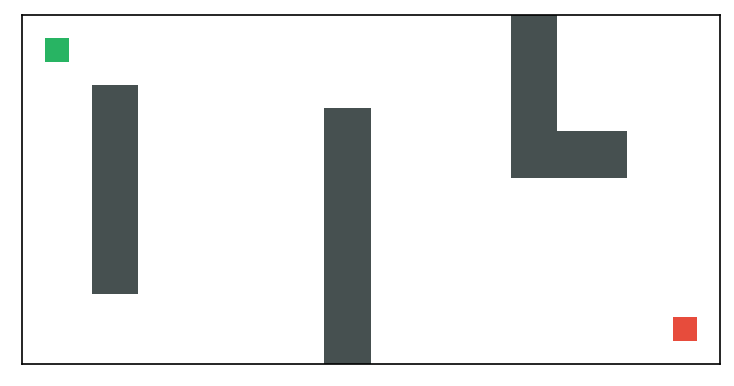

In [6]:
height = 15
width = 30
map_str = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

test_map = Map()
test_map.read_from_string(map_str, width, height)
start = Node(1, 1)
goal = Node(13, 28)
draw(test_map, start, goal)

### Implementing the search tree (i.e. OPEN and CLOSED)
Efficient implementation of the search tree (OPEN and CLOSED) is crucial for any search algorithm. Below you may find basic implementations that use lists to store the elements of OPEN and CLOSED. This is not very efficient. Your task is to create your own implementations.

It's a good idea to modify CLOSED first (as it is pretty straghtforward to do so). Then check that everything is OK, i.e. the search algorithms work faster and the result is correct. Then proceed to modifying OPEN (which is not that trivial as might seem).

PS: You may wish to add additional fields, methods, method-arguments etc. to your implementations.


In [7]:
class SearchTreeL: #SearchTree which uses Lists for OPEN and CLOSED (NOT EFFICIENT)
    
    def __init__(self):
        self._open: List[Node] = []           # list for the OPEN nodes
        self._closed: List[Node] = []       # list for the expanded nodes = CLOSED
        self._enc_open_dublicates = 0
        
    def __len__(self):
        return len(self._open) + len(self._closed)
                    
    '''
    open_is_empty should inform whether the OPEN is exhausted or not.
    In the former case the search main loop should be interrupted.
    '''
    def open_is_empty(self):
        return len(self._open) == 0
    
    '''
    Adding a (previously not expanded) node to the search-tree (i.e. to OPEN).
    It's either a totally new node (the one we never encountered before)
    or it can be a dublicate of the node that currently resides in OPEN.
    It's up to us how to handle dublicates in OPEN. We can either 
    detect dublicates upon adding (i.e. inside this method) or detect them
    lazily, when we are extracting a node for further expansion.
    Not detecting dublicates at all may work in certain setups but let's not
    consider this option.
    '''    
    def add_to_open(self, item: Node):
        for existing_node in self._open:
            if existing_node == item: #here we detect dublicates, so OPEN never contains them
                if existing_node.g > item.g:
                    existing_node.g = item.g
                    existing_node.f = item.f #actually not needed but just for the clarity
                    existing_node.parent = item.parent
                    return
                else:
                    return
        self._open.append(item)
        return    
    
    
    '''
    Extracting the best node (i.e. the one with the minimal key 
    = min f-value = min g-value (for Dijkstra)) from OPEN.
    This node will be expanded further on in the main loop of the search.
    ''' 
    def get_best_node_from_open(self):
        best_f = math.inf
        best_coord = 0
        for i in range(len(self._open)):
            if self._open[i].f < best_f:
                best_coord = i
                best_f = self._open[i].f
        best = self._open.pop(best_coord)
        return best

    def add_to_closed(self, item):
        self._closed.append(item)

    def was_expanded(self, item):
        return item in self._closed

    @property
    def OPEN(self):
        return self._open
    
    @property
    def CLOSED(self):
        return self._closed

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates
    

In [8]:
class SearchTreePQS: #Non list-based implementation of the search tree
    
    def __init__(self):
        self._open = []           # heap for the OPEN nodes
        self._closed = set()       # set for the expanded nodes = CLOSED
        self._enc_open_dublicates = 0
        
    def __len__(self):
        return len(self._open) + len(self._closed)
                    
    '''
    open_is_empty should inform whether the OPEN is exhausted or not.
    In the former case the search main loop should be interrupted.
    '''
    
    def open_is_empty(self):
        return len(self._open) == 0
    
    '''
    Adding a (previously not expanded) node to the search-tree (i.e. to OPEN).
    It's either a totally new node (the one we never encountered before)
    or it can be a dublicate of the node that currently resides in OPEN.
    It's up to us how to handle dublicates in OPEN. We can either 
    detect dublicates upon adding (i.e. inside this method) or detect them
    lazily, when we are extracting a node for further expansion.
    Not detecting dublicates at all may work in certain setups but let's not
    consider this option.
    '''    
    def add_to_open(self, item):
        heappush(self._open, item)   
    
    '''
    Extracting the best node (i.e. the one with the minimal key 
    = min f-value = min g-value (for Dijkstra)) from OPEN.
    This node will be expanded further on in the main loop of the search.
    ''' 
    
    def was_expanded(self, item):
        return item in self._closed
    
    def get_best_node_from_open(self):
        best_node = heappop(self._open)
        
        while self.was_expanded(best_node) and not self.open_is_empty():
            best_node = heappop(self._open)
        
        return best_node

    def add_to_closed(self, item):
        self._closed.add(item)

    @property
    def OPEN(self):
        return self._open
    
    @property
    def CLOSED(self):
        return self._closed

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates


### Validating the results


In [9]:
def make_path(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length


In [10]:
def read_task_from_file(path):
    '''
    Reads map, start/goal positions and true value of path length between given start and goal from file by path. 
    '''

    tasks_file = open(path)
    height = int(tasks_file.readline())
    width = int(tasks_file.readline())
    cells = [[0 for _ in range(width)] for _ in range(height)]
    i = 0
    j = 0

    for l in tasks_file:
        j = 0
        for c in l:
            if c == '.':
                cells[i][j] = 0
            elif c == '#':
                cells[i][j] = 1
            else:
                continue
            j += 1
            
        if j != width:
            raise Exception("Size Error. Map width = ", j, ", but must be", width, "(map line: ", i, ")")
                
        i += 1
        if(i == height):
            break
    
    start_i = int(tasks_file.readline())
    start_j = int(tasks_file.readline())
    goal_i = int(tasks_file.readline())
    goal_j = int(tasks_file.readline())
    length = float(tasks_file.readline())
    return (width, height, cells, start_i, start_j, goal_i, goal_j, length)


`simple_test` tests the pathfing algorithm on a single simple instance, `massive_test` - on a series of a move involved instances. Both tests assume that the search function fits the following pattern:


`search(task_map, start.i, start.j, goal.i, goal.j, *optional arguments*) -> (path_found, last_state, steps, nodes_created, discovered, expanded)`, where

- `task_map` -- grid
- `start.i, start.j` -- (i,j) coordinates of the start cell
- `goal.i, goal.j` -- (i,j) coordinates of the goal cell
- `*optional arguments*` -- additional parameters of the search function, passed with `*args`. E.g. the heuristic function.
- `path_found` -- `True` if path was found, `False` otherwise
- `last_state` -- last state of the path. `None` if path was not found
- `steps` -- the number of search steps
- `nodes_created` -- the number of nodes, which were created and stored during the search process 
- `discovered` -- iterable collection of discovered nodes
- `expanded` --  iterable collection of expanded nodes

In [11]:
def simple_test(search_func, task, *args):
    '''
    simple_test runs search_func on one task (use a number from 0 to 25 to choose a certain debug task on simple map or None to choose a random task from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task
    '''
    
    height = 15
    width = 30
    map_str = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

    task_map = Map()
    task_map.read_from_string(map_str, width, height)
    starts = [(9, 0), (13, 0), (7, 28), (14, 29), (4, 1), (0, 17), (5, 6), (5, 20), (12, 2), (7, 28), (11, 9), (3, 2), (3, 17), (13, 20), (1, 1), (9, 10), (14, 6), (2, 0), (9, 28), (8, 6), (11, 6), (3, 0), (8, 9), (14, 7), (12, 4)]
    goals = [(11, 20), (2, 19), (6, 5), (4, 18), (9, 20), (7, 0), (2, 25), (12, 4), (3, 25), (0, 12), (4, 23), (2, 24), (9, 2), (1, 6), (13, 29), (14, 29), (2, 28), (14, 16), (13, 0), (1, 27), (14, 25), (10, 20), (12, 28), (2, 29), (1, 29)]
    lengths = [36, 30, 30, 21, 28, 24, 32, 27, 42, 23, 35, 37, 23, 26, 40, 36, 42, 28, 44, 36, 38, 29, 33, 42, 44]

    if (task is None) or not (0 <= task < 25):
        task = randint(0, 24)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    length = lengths[task]
    try:
        result = search_func(task_map, start.i, start.j, goal.i, goal.j, *args)
        number_of_steps = result[2]
        nodes_created = result[3]
        if result[0]:
            path = make_path(result[1])
            correct = int(path[1])  == int(length)
            draw(task_map, start, goal, path[0], *result[4:])
            print("Path found! Length: " + str(path[1]) + \
                ". Nodes created: " + str(nodes_created) + \
                ". Number of steps: " + str(number_of_steps) + ". Correct: " + str(correct))
        else:
            print("Path not found!")
        return result

    except Exception as e:
        print("Execution error")
        print(e)


In [12]:
def massive_test(search_func, data_path, num_of_tasks=None, *args):
    '''
    massive_test runs search_func on set of differnt tasks (from directory data/) 
    with *args as optional arguments and 
    for every task displays the short report:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task.
    
    the function also returns a dictionary with statistics. 
    It contains the next fields:
     - "corr" -- the correctness of every path length (True/False)
     - "len" -- the length of every path (0.0 if path not found)
     - "nc" -- the number of created nodes for every task execution
     - "st" -- the number of steps of algorithm for every task execution
    '''
    
    stat = dict()
    stat["corr"] = []
    stat["len"] = []
    stat["nc"] = []
    stat["st"] = []
    
    if (num_of_tasks is None) or (num_of_tasks<=0):
        print("Incorrect number of tasks. Testing halted!")
        return stat
    
    task_num = num_of_tasks
    task_map = Map()
    for task_count in range(task_num):
        task_file_name = data_path + str(task_count) + ".map"
        width, height, cells, start_i, start_j, goal_i, goal_j, length = read_task_from_file(task_file_name)
        task_map.set_grid_cells(width, height, cells)
        try:
            result = search_func(task_map, start_i, start_j, goal_i, goal_j, *args)
            number_of_steps = result[2]
            nodes_created = result[3]
            if result[0]:
                path = make_path(result[1]) 
                stat["len"].append(path[1])
                correct = int(path[1])  == int(length)
                draw(task_map, start, goal, path[0], *result[4:])
                stat["corr"].append(correct)
                print("Path found! Length: " + str(path[1]) +\
                    ". Nodes created: " + str(nodes_created) + \
                    ". Number of steps: " + str(number_of_steps) + \
                    ". Correct: " + str(correct))
            else:
                print("Path not found!")
                stat["corr"].append(False)
                stat["len"].append(0.0)

            stat["nc"].append(nodes_created)
            stat["st"].append(number_of_steps)

        except Exception as e:
            print("Execution error")
            print(e)

    return stat


## Dijkstra algorithm

The input is:
- map
- start/goal
- heuristic function *
- the reference to the implementation of the SearchTree

/* Please note, that technically there is no need to pass heuristic function to Dijkstra's algorithm. However to unify it with A* (a heuristic search algorithm we will implement in the next lab) we keep this parameter as a take-in argument.

The output is:
- path found flag (`true` or `false`)
- last node of the path (so one can unwind it using the parent-pointers and get the full path)
- the number of steps (iterations of the main loop)
- the number of created and stored in memory search nodes (= the memory footprint of the algorithm)
- OPEN and CLOSED (as iterable collections of nodes) for further visualization purposes

In [13]:
def dijkstra(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, search_tree = None):
    '''
    TODO
    '''

    dst = search_tree() #Dijkstra's search tree
    steps = 0
    nodes_created = 0
    
    start_node = Node(start_i, start_j)
    dst.add_to_open(start_node)
    
    while not dst.open_is_empty():
        steps += 1
        
        best_node = dst.get_best_node_from_open()
        
        if best_node.is_goal(goal_i, goal_j):
            return (True, best_node, steps, nodes_created, dst.OPEN, dst.CLOSED)
        
        neighbours = grid_map.get_neighbors(best_node.i, best_node.j)
        for neigh in neighbours:
            neigh_node = Node(neigh[0], neigh[1], best_node.g + compute_cost(best_node.i, best_node.j, neigh[0], neigh[1]), parent=best_node)
            nodes_created += 1
            
            if not dst.was_expanded(neigh_node):
                dst.add_to_open(neigh_node)
        dst.add_to_closed(best_node)
    
    CLOSED = dst.CLOSED 
    return (False, None, steps, nodes_created, None, CLOSED)

Now let's test the implementation.

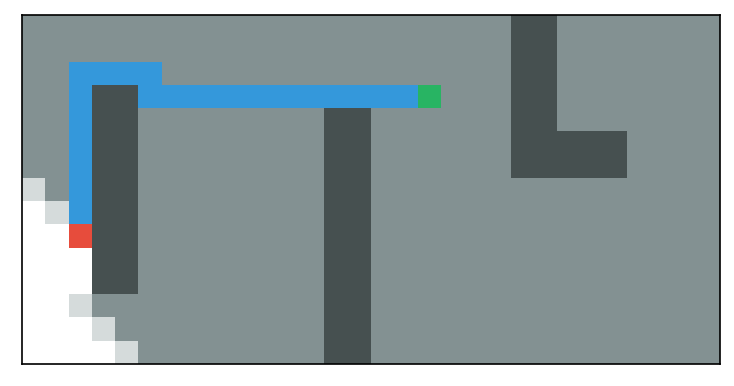

Path found! Length: 23. Nodes created: 1326. Number of steps: 367. Correct: True
CPU times: total: 78.1 ms
Wall time: 88 ms


In [14]:
'''
This should work correct in case your implementation of Dijkstra is correct.
Play with the number of test instance (2nd argument) to run
the search algorithm on different start/goal pairs.
'''
%time res = simple_test(dijkstra, 12, None, SearchTreeL)

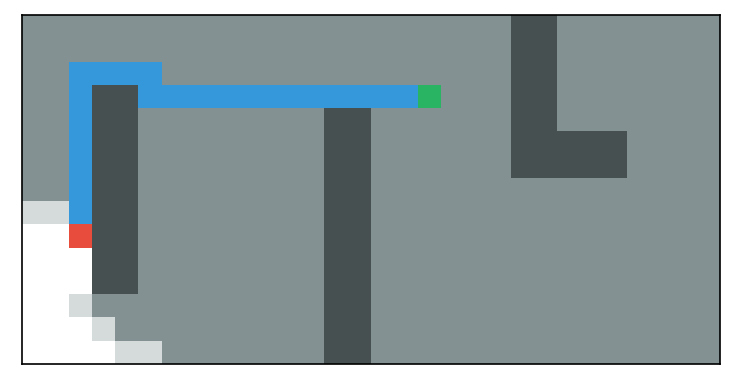

Path found! Length: 23. Nodes created: 1326. Number of steps: 367. Correct: True
CPU times: total: 78.1 ms
Wall time: 63.3 ms


In [15]:
'''
This should work correct in case your plementation of Dijkstra is correct.
Play with the number of test instance (2nd argument) to run
the search algorithm on different start/goal pairs.
'''
%time res = simple_test(dijkstra, 12, None, SearchTreePQS)

In [16]:
'''
This runs the search algorithm on two larger instances.
The default (list-based) implementation of OPEN/CLOSED will be slow.
'''
# %time res = dijk_stat = massive_test(dijkstra, "data/", 2, None, SearchTreeL)

'\nThis runs the search algorithm on two larger instances.\nThe default (list-based) implementation of OPEN/CLOSED will be slow.\n'

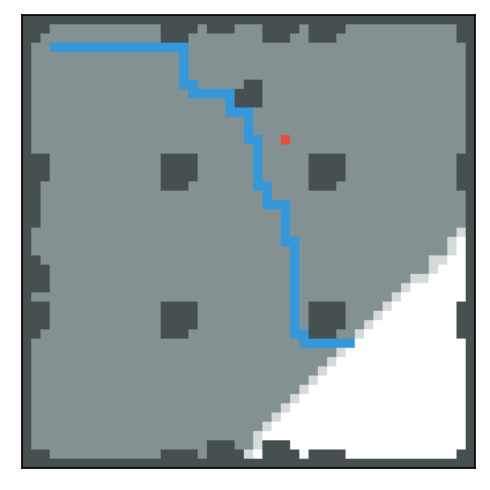

Path found! Length: 64. Nodes created: 6748. Number of steps: 1750. Correct: True


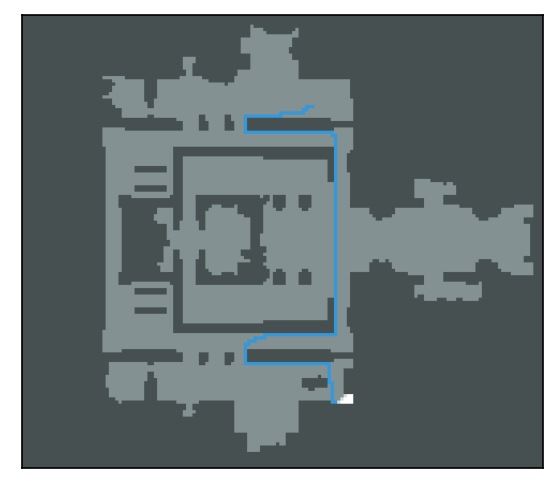

Path found! Length: 197. Nodes created: 27886. Number of steps: 7449. Correct: True
CPU times: total: 344 ms
Wall time: 348 ms


In [17]:
'''
This runs the search algorithm on two larger instances.
With your (non list-based) implementation of OPEN/CLOSED it should be much faster
'''
%time res = dijk_stat = massive_test(dijkstra, "data/", 2, None, SearchTreePQS)

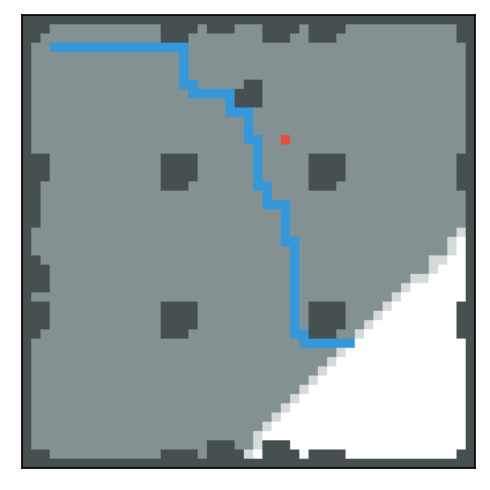

Path found! Length: 64. Nodes created: 6748. Number of steps: 1750. Correct: True


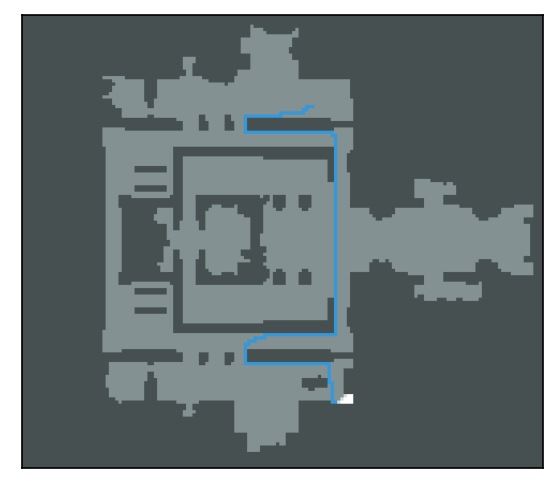

Path found! Length: 197. Nodes created: 27886. Number of steps: 7449. Correct: True


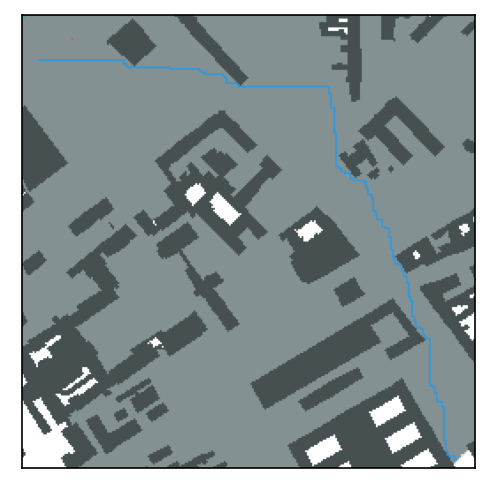

Path found! Length: 462. Nodes created: 178065. Number of steps: 45896. Correct: True


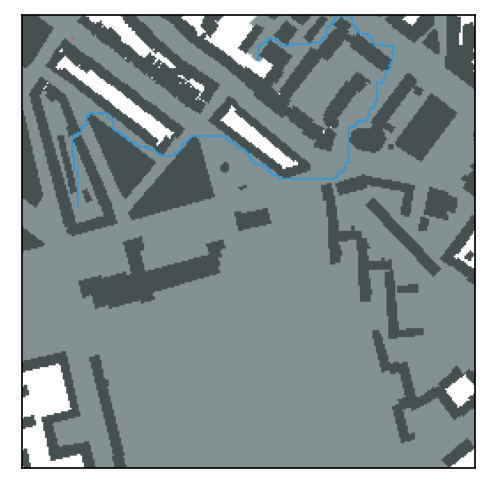

Path found! Length: 498. Nodes created: 171697. Number of steps: 44441. Correct: True


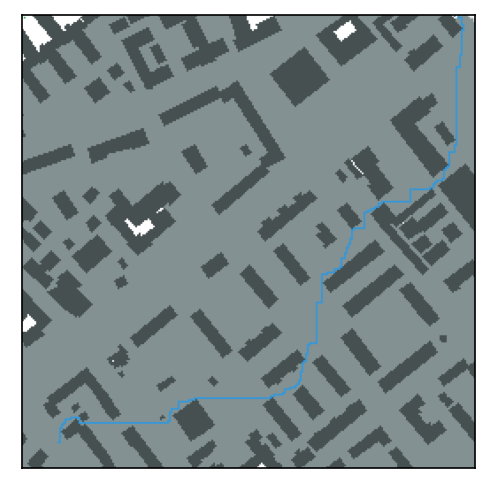

Path found! Length: 479. Nodes created: 181972. Number of steps: 47533. Correct: True


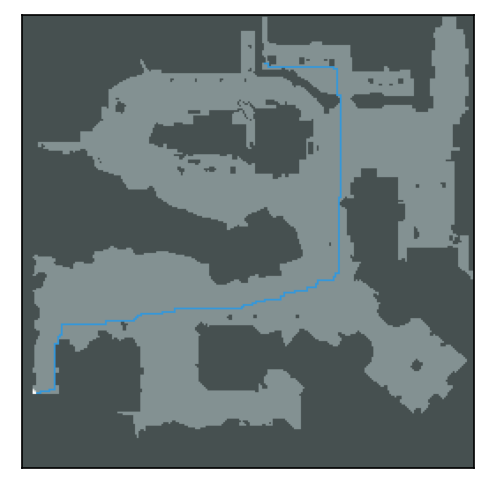

Path found! Length: 402. Nodes created: 108938. Number of steps: 28173. Correct: True


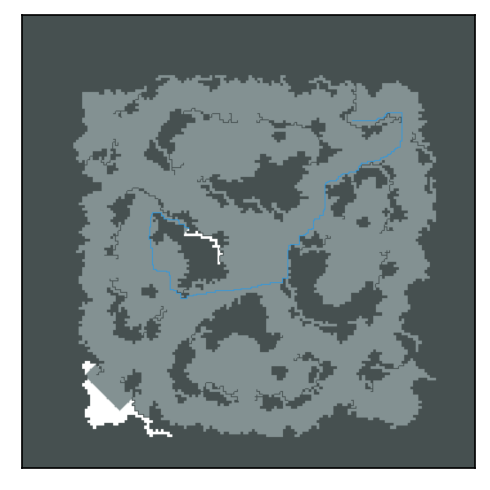

Path found! Length: 721. Nodes created: 436618. Number of steps: 112406. Correct: True


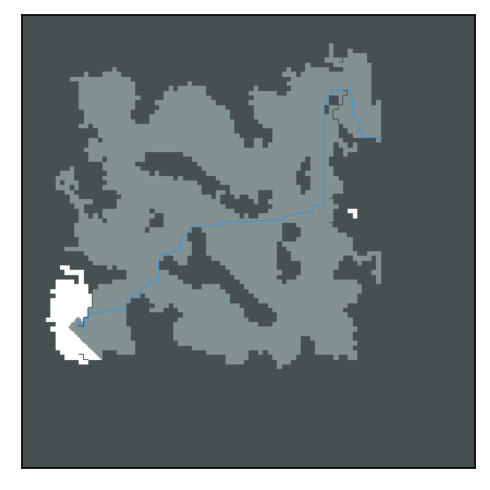

Path found! Length: 678. Nodes created: 304198. Number of steps: 77376. Correct: True


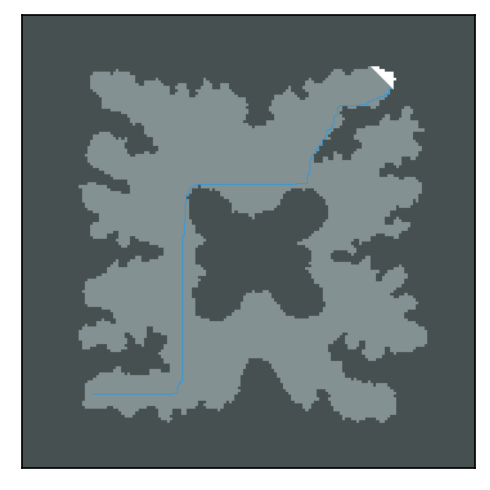

Path found! Length: 683. Nodes created: 377874. Number of steps: 95875. Correct: True
CPU times: total: 12.1 s
Wall time: 12.1 s


In [18]:
'''
Finally, let's run your (efficient) implementation of Dijkstra on the full set of
large instances (9 instances in total). All should be correct.

On my modern laptop (2022 Asus, Intel iCore7, 16Gb RAM, SSD) the whole test completes 
in about 5-7 seconds.
'''
%time res = dijk_stat = massive_test(dijkstra, "data/", 9, None, SearchTreePQS)